In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# !pip install pyarrow fastparquet

In [4]:
parquet_file = "data/eco2mix.parquet"
df = pd.read_parquet(parquet_file)

csv_file = "data/eco2mix.csv"
df.to_csv(csv_file, index=False)

### 1 - Aggregation of Energy Production and Consumption by Month and Region

In [5]:
# Convert "Date - Time" column to datetime and extract the month
df['Month'] = pd.to_datetime(df['Date - Time']).dt.month

# Grouping by "Month" and "Region" and performing the required aggregations
result_df = df.groupby(['Month', 'Region']).agg(
    Production_GWh=('Production (MW)', lambda x: x.sum() * 0.001),
    Consumption_GWh=('Consumption (MW)', lambda x: x.sum() * 0.001),
    Max_Production_MW=('Production (MW)', 'max'),
    Min_Production_MW=('Production (MW)', 'min'),
    Avg_Production_MW=('Production (MW)', lambda x: x.mean()),
    Max_Consumption_MW=('Consumption (MW)', 'max'),
    Min_Consumption_MW=('Consumption (MW)', 'min'),
    Avg_Consumption_MW=('Consumption (MW)', 'mean')
).reset_index()

result_df

,Month,Region,Production_GWh,Consumption_GWh,Max_Production_MW,Min_Production_MW,Avg_Production_MW,Max_Consumption_MW,Min_Consumption_MW,Avg_Consumption_MW
0,1,Auvergne-Rhône-Alpes,234809.135,143428.059,21844.0,8987.0,15781.244371,12882.0,6583.0,9639.630284
1,1,Bourgogne-Franche-Comté,7937.258,46325.143,1418.0,104.0,533.453727,4339.0,2042.0,3113.458095
2,1,Bretagne,8543.951,50122.331,1599.0,43.0,574.228846,4914.0,1987.0,3368.662612
3,1,Centre-Val de Loire,163962.928,43034.191,12651.0,7265.0,11019.754553,4156.0,1827.0,2892.277102
4,1,Grand Est,206023.173,95145.314,18689.0,7073.0,13846.573896,8509.0,3946.0,6394.604073
...,...,...,...,...,...,...,...,...,...,...
139,12,Nouvelle-Aquitaine,88003.413,81281.131,9159.0,3416.0,6571.342070,8546.0,3129.0,6069.379555
140,12,Occitanie,53945.721,71828.667,7711.0,1055.0,4028.204973,7426.0,3135.0,5363.550403
141,12,Pays de la Loire,14584.924,50612.515,2926.0,142.0,1089.077360,5679.0,2167.0,3779.309662
142,12,Provence-Alpes-Côte d'Azur,32072.890,75583.670,5105.0,525.0,2394.929062,7529.0,3891.0,5643.941906


The results allow for the analysis of seasonal and regional trends in energy production and consumption, as well as the detection of peak periods and variations in energy demand. It also highlights whether high consumption or production occurs in specific regions and vice versa.

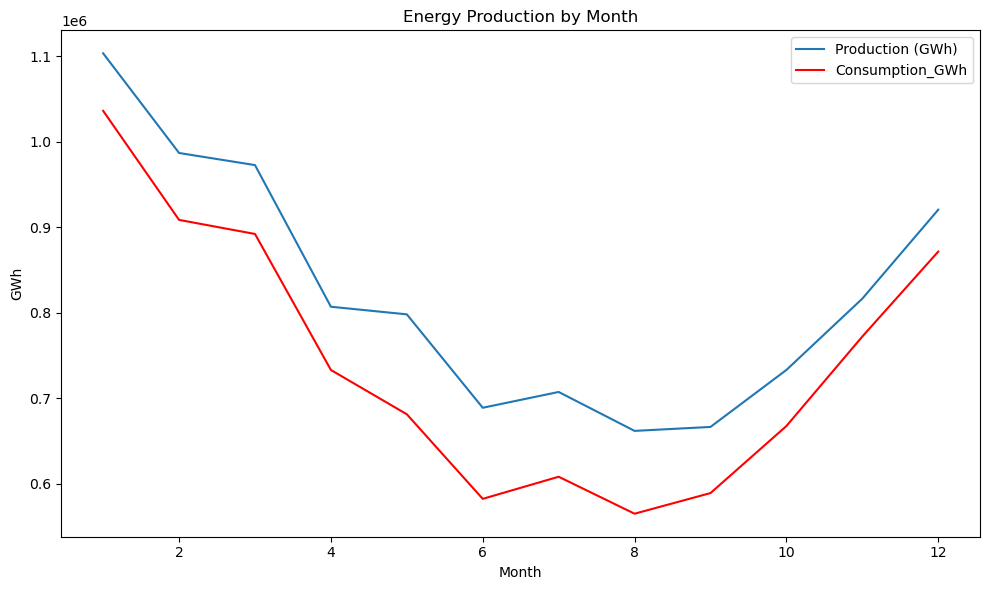

In [6]:
# Data aggregation
df['Month'] = pd.to_datetime(df['Date - Time']).dt.month

# Group by month and aggregate production and consumption to GWh
monthly_data = df.groupby('Month').agg(
    Production_GWh=('Production (MW)', lambda x: x.sum() * 0.001),
    Consumption_GWh=('Consumption (MW)', lambda x: x.sum() * 0.001)
).reset_index()

plt.figure(figsize=(10, 6))

plt.plot(monthly_data['Month'], monthly_data['Production_GWh'], label='Production (GWh)')
plt.title('Energy Production by Month')
plt.xlabel('Month')
plt.ylabel('GWh')
plt.legend()

plt.plot(monthly_data['Month'], monthly_data['Consumption_GWh'], label='Consumption_GWh', color='red')
plt.title('Energy Production by Month')
plt.xlabel('Month')
plt.ylabel('GWh')
plt.legend()

plt.tight_layout()
plt.show()

Overall, the graphs are similar, but there is a difference in scale, with production being higher than consumption. However, the graphs are almost correlated.

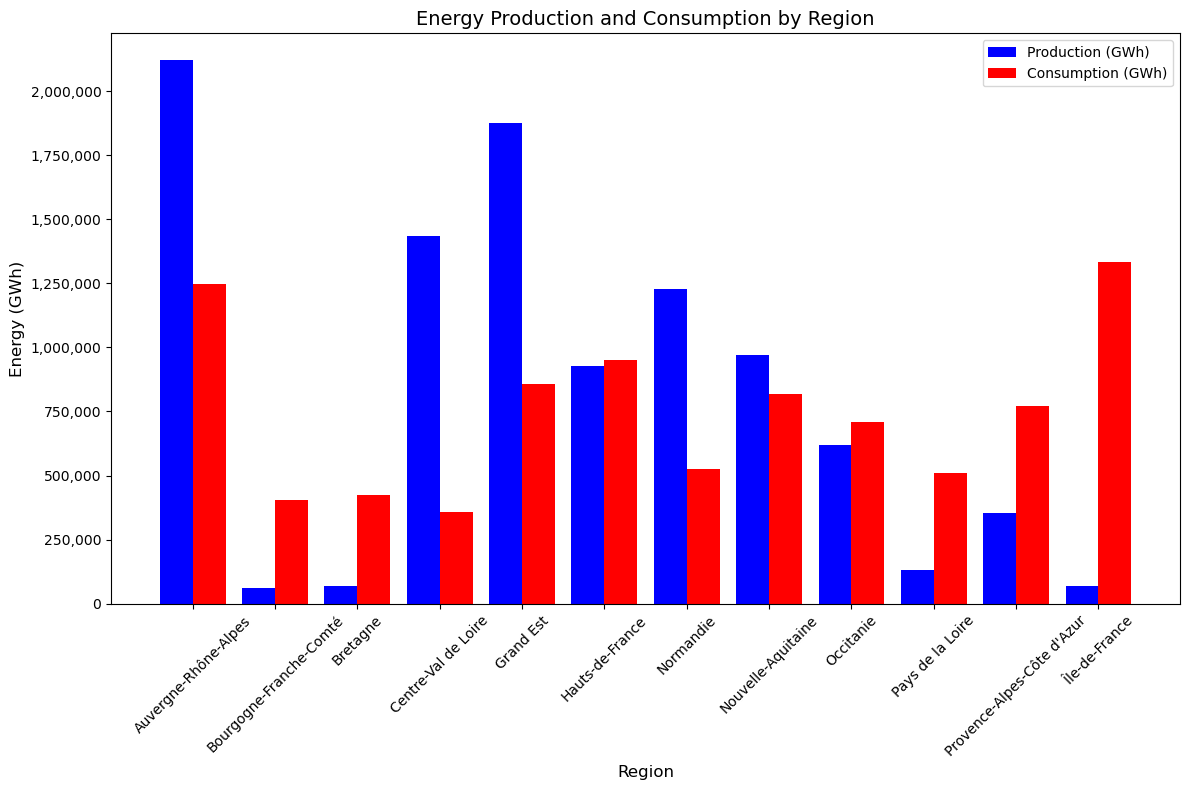

In [7]:

import matplotlib.ticker as mticker
# Aggregation of energy production and consumption by region
regional_data = df.groupby('Region').agg(
    Production_GWh=('Production (MW)', lambda x: x.sum() * 0.001),
    Consumption_GWh=('Consumption (MW)', lambda x: x.sum() * 0.001)
).reset_index()

# Create x positions for the bars
x_positions = np.arange(len(regional_data['Region']))

# Width of each bar
bar_width = 0.4

plt.figure(figsize=(12, 8))
plt.bar(x_positions, regional_data['Production_GWh'], width=bar_width, color='blue', label='Production (GWh)')
plt.bar(x_positions + bar_width, regional_data['Consumption_GWh'], width=bar_width, color='red', label='Consumption (GWh)')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Energy Production and Consumption by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Energy (GWh)', fontsize=12)
plt.xticks(x_positions + bar_width / 2, regional_data['Region'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


- Regions like Auvergne-Rhône-Alpes, Centre-Val de Loire, and Normandie produce far more energy than they consume, acting as exporters.

- Île-de-France and Provence-Alpes-Côte d'Azur consume significantly more energy than they produce, relying on imports.

- Areas such as Grand Est and Nouvelle-Aquitaine show similar levels of production and consumption.

- Energy production and consumption vary widely, reflecting differences in infrastructure, population, and industrial activity.

### 2 - Daily Energy Consumption by Region (GWh)

In [8]:
# Convert "Date - Time" to datetime and truncate to the month
df['DATE'] = pd.to_datetime(df['Date - Time']).dt.to_period('M').dt.to_timestamp()

# Aggregate the consumption for each region
result_df = (
    df.groupby('DATE').apply(
        lambda x: pd.Series({
            'Centre-Val de Loire': (x.loc[x['Region'] == 'Centre-Val de Loire', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Bourgogne-Franche-Comté': (x.loc[x['Region'] == 'Bourgogne-Franche-Comté', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Île-de-France': (x.loc[x['Region'] == 'Île-de-France', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Normandie': (x.loc[x['Region'] == 'Normandie', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Grand Est': (x.loc[x['Region'] == 'Grand Est', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Provence-Alpes-Côte d\'Azur': (x.loc[x['Region'] == 'Provence-Alpes-Côte d\'Azur', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Occitanie': (x.loc[x['Region'] == 'Occitanie', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Nouvelle-Aquitaine': (x.loc[x['Region'] == 'Nouvelle-Aquitaine', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Pays de la Loire': (x.loc[x['Region'] == 'Pays de la Loire', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Hauts-de-France': (x.loc[x['Region'] == 'Hauts-de-France', 'Consumption (MW)'].sum() * 0.5 * 0.001),
            'Bretagne': (x.loc[x['Region'] == 'Bretagne', 'Consumption (MW)'].sum() * 0.5 * 0.001),
        })
    )
).reset_index()

result_df

C:\Users\arthu\AppData\Local\Temp\ipykernel_35556\658343733.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('DATE').apply(


,DATE,Centre-Val de Loire,Bourgogne-Franche-Comté,Île-de-France,Normandie,Grand Est,Provence-Alpes-Côte d'Azur,Occitanie,Nouvelle-Aquitaine,Pays de la Loire,Hauts-de-France,Bretagne
0,2013-01-01,2209.4810,2352.4330,8413.2680,3248.4465,4866.2045,4599.0030,4309.1800,4914.0510,3061.6975,5528.2190,2527.8695
1,2013-02-01,2070.5030,2203.1275,7806.7245,3014.1295,4589.9165,4273.9990,3876.4120,4481.9990,2860.5750,5030.4295,2319.1060
2,2013-03-01,2036.3125,2194.2365,7801.8905,3149.7490,4703.8820,4142.7260,3693.8760,4332.1490,2888.4160,5252.1925,2460.3515
3,2013-04-01,1607.6215,1795.1125,6226.5320,2536.9565,3886.7060,3322.6630,3021.1495,3541.0005,2362.7415,4345.4105,2014.4720
4,2013-05-01,1434.7330,1722.2700,5574.0415,2228.3475,3618.8725,3070.7150,2728.5985,3341.1525,2029.8760,4105.7535,1680.8495
...,...,...,...,...,...,...,...,...,...,...,...,...
108,2022-01-01,2256.9920,2361.7280,7709.7840,2937.0945,4663.0875,4500.9340,4529.9525,5085.8765,3049.0955,5042.8250,2551.7095
109,2022-02-01,1825.1875,1962.2335,6343.1750,2523.6715,4016.0740,3595.7520,3450.3270,4000.1430,2483.4275,4326.4195,2154.2110
110,2022-03-01,1706.0935,1903.2990,6282.5690,2481.9125,4217.8585,3777.2200,3513.0250,3838.9635,2413.9865,4369.3980,2101.9570
111,2022-04-01,1460.1670,1645.5420,5486.8055,2190.2290,3564.9165,3054.0635,2985.1985,3422.2290,2092.9255,3940.0875,1787.7000


The SQL query creates a pivot table showing the monthly energy consumption (in GWh) by region. Each row represents a specific month, and each column corresponds to a different region in France.
This pivot table allows for a comparative analysis of energy consumption across different regions on a monthly basis, providing insights into regional variations and trends over time.

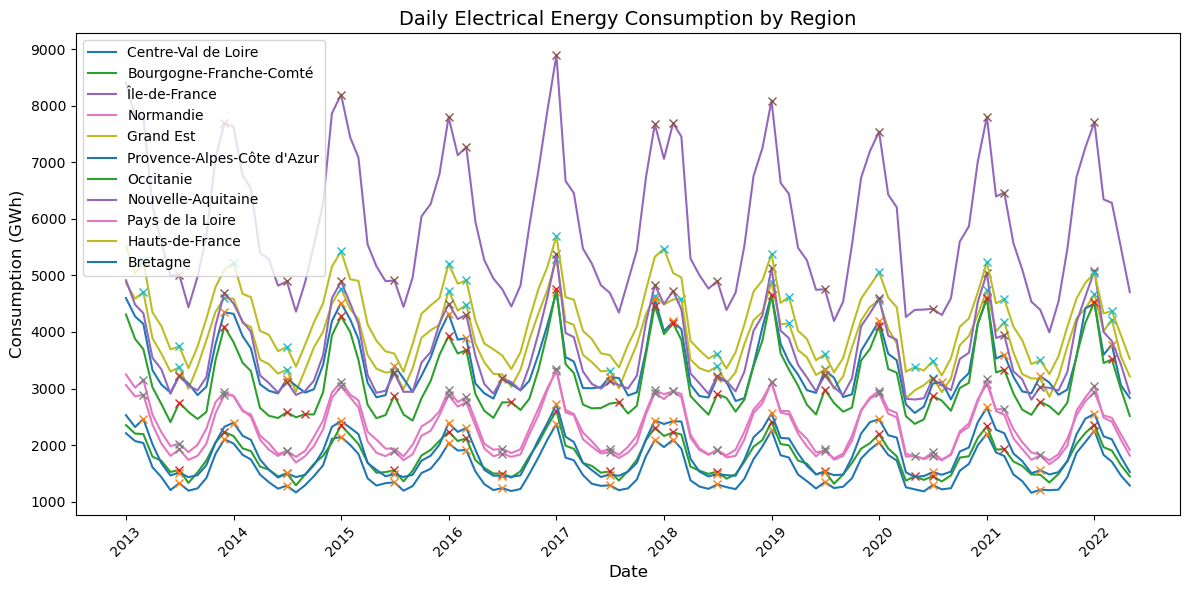

In [9]:
from scipy.signal import find_peaks
plt.figure(figsize=(12, 6))

# Loop through each region column to plot the data and detect peaks
for region in result_df.columns[1:]:  # Exclude the "DATE" column
    plt.plot(result_df["DATE"], result_df[region], label=region)  # Plot each region's data
    peaks, _ = find_peaks(result_df[region])  # Detect peaks
    plt.plot(result_df["DATE"].iloc[peaks], result_df[region].iloc[peaks], "x")  # Mark peaks with 'x'
plt.title("Daily Electrical Energy Consumption by Region", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Consumption (GWh)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

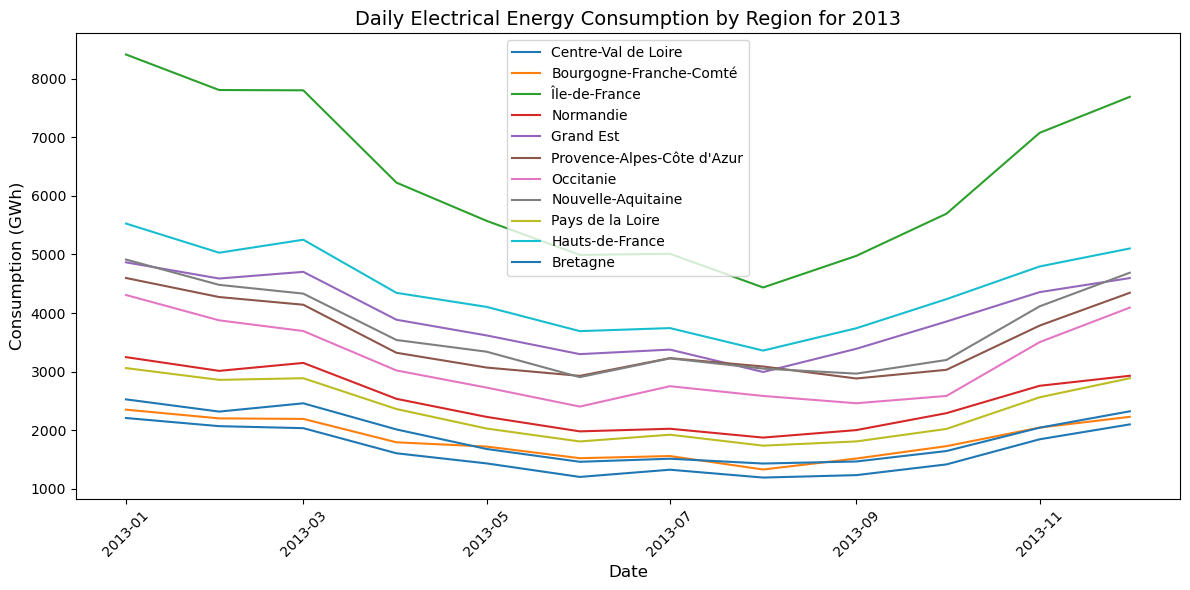

In [10]:
# Filter the data for the year 2013
data_2013 = result_df[result_df["DATE"].dt.year == 2013]

# Create the plot
plt.figure(figsize=(12, 6))

# Loop through each region column to plot the data
for region in data_2013.columns[1:]:  # Exclude the "Month" column
    plt.plot(data_2013["DATE"], data_2013[region], label=region)  # Plot data for each region


plt.title("Daily Electrical Energy Consumption by Region for 2013", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Consumption (GWh)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Using the two graphs, we can observe consumption peaks during the end-of-year periods in each region.

### 3 - The daily energy consumption (GWh) for the past month.

In [11]:
# Convert "Date - Time" to datetime and truncate to day
df['Date'] = pd.to_datetime(df['Date - Time']).dt.floor('D')

# Calculate daily total consumption
daily_consumption = (
    df.groupby('Date').agg(
        TotalConsumptionGWh=('Consumption (MW)', lambda x: x.sum() * 0.001 * 0.5)
    ).reset_index()
)

# Use rolling window to calculate the past month's consumption
daily_consumption['MonthlyConsumptionGWh'] = (
    daily_consumption.set_index('Date')  # Set Date as index
    .rolling('30D', min_periods=1)['TotalConsumptionGWh']  # Apply rolling on the indexed DataFrame
    .sum()
    .values  # Convert back to Series without the index affecting DataFrame
)

# Sort by date
daily_consumption = daily_consumption.sort_values('Date')

daily_consumption

,Date,TotalConsumptionGWh,MonthlyConsumptionGWh
0,2013-01-01,1278.2975,1278.2975
1,2013-01-02,1547.7970,2826.0945
2,2013-01-03,1599.3820,4425.4765
3,2013-01-04,1565.6995,5991.1760
4,2013-01-05,1443.4110,7434.5870
...,...,...,...
3433,2022-05-27,975.7435,31591.6190
3434,2022-05-28,929.6050,31376.8300
3435,2022-05-29,912.2655,31169.1175
3436,2022-05-30,1061.4880,31220.8290


This query is useful for analyzing energy consumption trends over a one-month period and observing how consumption evolves over time.

### 4 - Top 20 Largest Daily Consumption Differences (GWh)

In [12]:
# Calculate daily total consumption
df['Date'] = pd.to_datetime(df['Date - Time']).dt.floor('D')  # Truncate to day
daily_consumption = (
    df.groupby('Date')
    .agg(TotalConsumptionGWh=('Consumption (MW)', lambda x: x.sum() * 0.001 * 0.5))  # Total consumption in GWh
    .reset_index()
)

# Calculate the variation using shift
daily_consumption['Variation'] = abs(
    daily_consumption['TotalConsumptionGWh'] - daily_consumption['TotalConsumptionGWh'].shift(1)
)

# Sort by variation in descending order and select the top 20
top_variations = daily_consumption.sort_values(by='Variation', ascending=False).head(20)

top_variations


,Date,TotalConsumptionGWh,Variation
2127,2018-10-29,1523.4765,313.5685
734,2015-01-05,1710.5980,297.5080
69,2013-03-11,1584.4775,292.9950
2960,2021-02-08,1701.4360,287.1560
1117,2016-01-23,1570.0700,284.4365
2148,2018-11-19,1644.3480,282.7660
1777,2017-11-13,1542.6680,281.6945
1770,2017-11-06,1467.6250,279.6990
1406,2016-11-07,1571.9825,278.5770
1882,2018-02-26,1965.1580,278.5755


The information can be useful for analyzing days with significant changes in energy consumption.

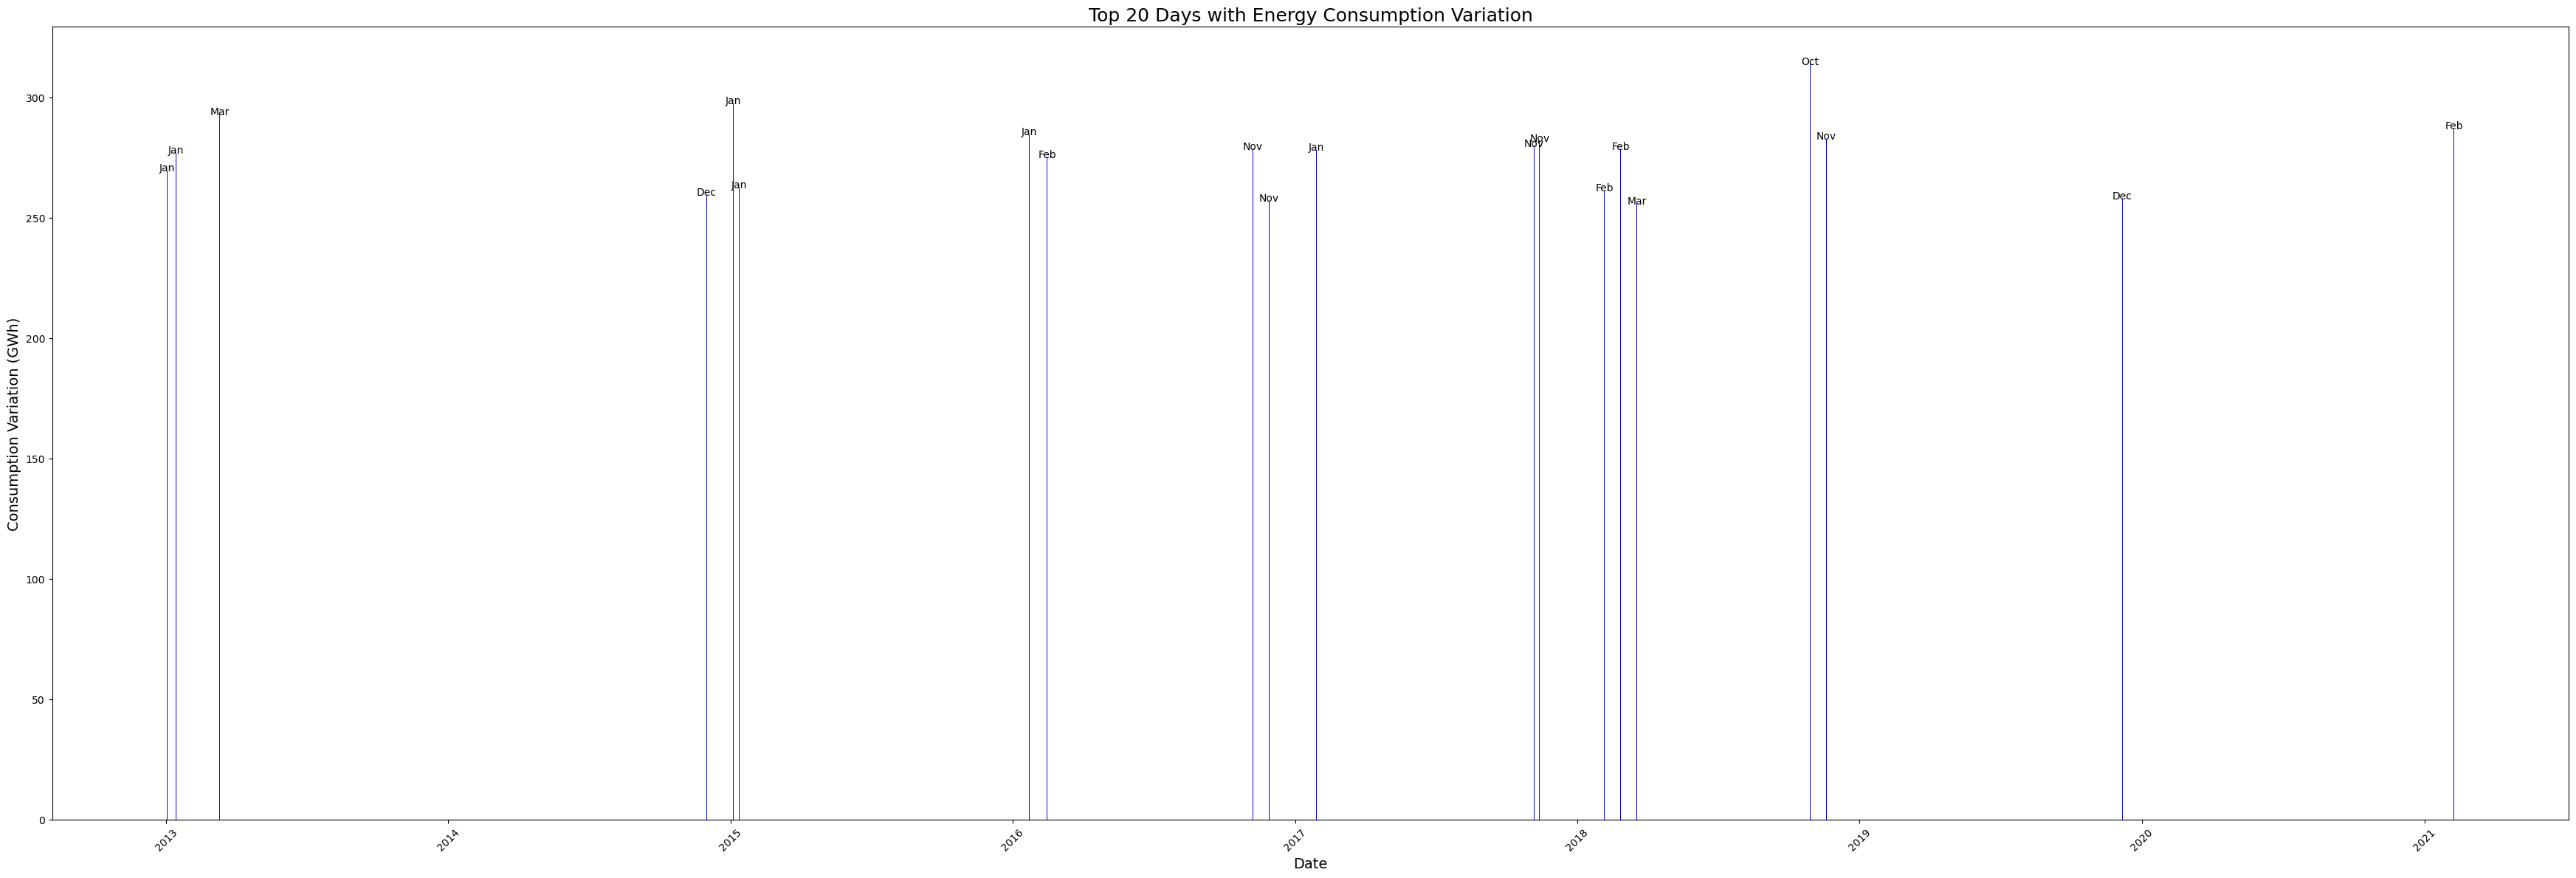

In [13]:
# Convert "Date" column to datetime
top_variations["Date"] = pd.to_datetime(top_variations["Date"])

# Create the plot
plt.figure(figsize=(35, 12))
plt.bar(top_variations["Date"], top_variations["Variation"], color='b')
for index, row in top_variations.iterrows():
    plt.text(row["Date"], row["Variation"], row["Date"].strftime('%b'), ha='center', fontsize=10)
plt.title("Top 20 Days with Energy Consumption Variation", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Consumption Variation (GWh)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


It is observed that January, December, February, and November are the most frequently represented months, likely because consumption variations tend to increase during winter.

### 5 - Day of Renewable Energy Surpass for Each Year (2013–2021)

In [14]:
# Add a new column for renewable production
df['Renewable Production (MW)'] = (
    df['Hydraulic (MW)'] +
    df['Bioenergies (MW)'] +
    df['Wind (MW)'] +
    df['Solar (MW)'] +
    df['Pumping (MW)']
)

# Extract year and truncate datetime to day
df['Year'] = pd.to_datetime(df['Date - Time']).dt.year
df['Date'] = pd.to_datetime(df['Date - Time']).dt.floor('D')

# Calculate annual renewable energy production
renew = (
    df.groupby('Year').agg(
        production_annuelle=('Renewable Production (MW)', 'sum')
    ).reset_index()
)

# Calculate daily total consumption
daily = df.groupby(['Date', 'Year']).agg(
    daily_total=('Consumption (MW)', 'sum')
).reset_index()

# Calculate cumulative consumption
daily['consommation_cumulee'] = daily.groupby('Year')['daily_total'].cumsum()

# Merge cumulative consumption with renewable production
conso = daily.merge(renew, on='Year')

# Filter rows where cumulative consumption exceeds annual production
filtered = conso[conso['consommation_cumulee'] >= conso['production_annuelle']]

# Get the first date per year where this happens
result = (
    filtered.groupby('Year').apply(
        lambda x: x.loc[x['Date'] == x['Date'].min()]
    ).reset_index(drop=True)
)

# Select required columns and sort results
result = result[['Year', 'Date', 'consommation_cumulee', 'production_annuelle']]
result.rename(columns={'consommation_cumulee': 'Consommation'}, inplace=True)
result = result.sort_values('Year')

result


C:\Users\arthu\AppData\Local\Temp\ipykernel_35556\3415298347.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered.groupby('Year').apply(


,Year,Date,Consommation,production_annuelle
0,2013,2013-02-24,190072991.0,187664990.0
1,2014,2014-02-26,180082634.0,179517516.0
2,2015,2015-02-21,178404308.0,175856211.0
3,2016,2016-02-29,192096349.0,188999321.0
4,2017,2017-02-20,177469971.0,176771711.0
5,2018,2018-03-06,217068532.0,216537478.0
6,2019,2019-03-08,218343791.0,217295395.0
7,2020,2020-03-20,241106351.0,240769122.0
8,2021,2021-03-14,230536889.0,229368777.0
9,2022,2022-01-30,100967780.0,100604535.0


This analysis identifies the first day each year (2013–2021) when cumulative renewable energy production surpasses cumulative energy consumption.

Renewable Production: Annual production from hydraulic, bioenergies, wind, solar, and pumping is calculated.
Daily Consumption: Total daily energy consumption is summed and accumulated.
Exceedance Date: The first day where cumulative consumption meets or exceeds renewable production is determined.


In [15]:
# Extract year from "Date - Time"
df['Year'] = pd.to_datetime(df['Date - Time']).dt.year

# Calculate total annual consumption
annual_consumption = (
    df.groupby('Year').agg(
        Total_consumption=('Consumption (MW)', 'sum')
    ).reset_index()
)

# Sort by year
annual_consumption = annual_consumption.sort_values('Year')

annual_consumption


,Year,Total_consumption
0,2013,984134263.0
1,2014,924697156.0
2,2015,946305720.0
3,2016,960630996.0
4,2017,958089446.0
5,2018,951041999.0
6,2019,940954352.0
7,2020,893165536.0
8,2021,934392855.0
9,2022,413254348.0


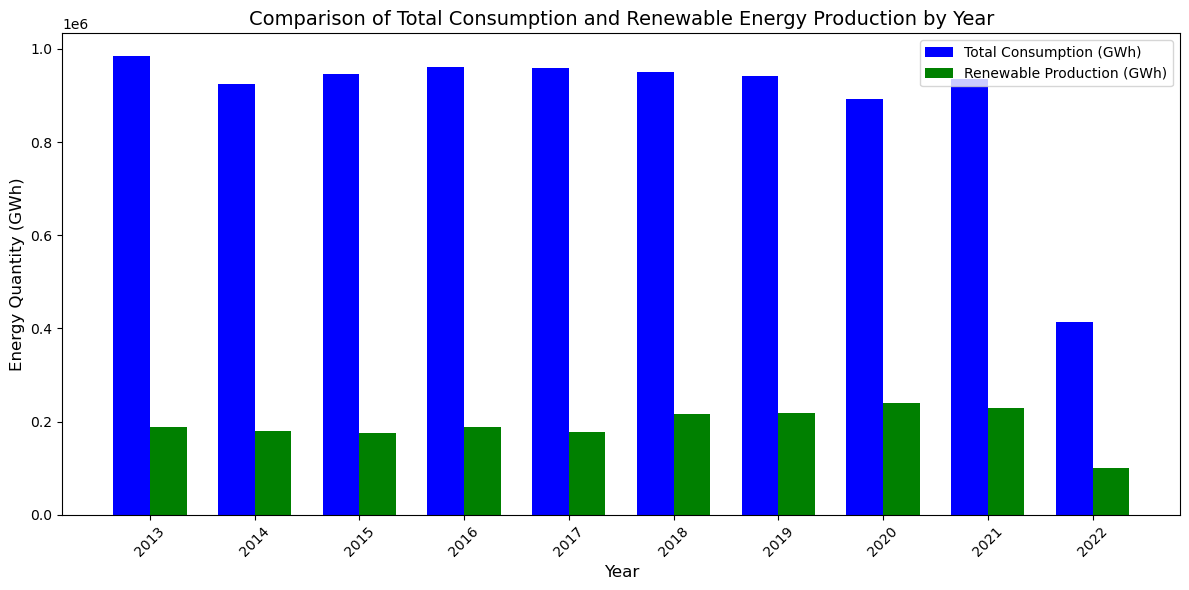

In [16]:
plot_data = annual_consumption.merge(result, on='Year')

# Define bar width and index
bar_width = 0.35
index = np.arange(len(plot_data['Year']))

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(index, plot_data['Total_consumption'] * 0.001, bar_width, label="Total Consumption (GWh)", color='b')
plt.bar(index + bar_width, plot_data['production_annuelle'] * 0.001, bar_width, label="Renewable Production (GWh)", color='g')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Energy Quantity (GWh)", fontsize=12)
plt.title("Comparison of Total Consumption and Renewable Energy Production by Year", fontsize=14)
plt.xticks(index + bar_width / 2, plot_data['Year'].astype(int), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


We can observe that renewable energy production accounts for approximately one-third to one-fourth of the total energy consumption.

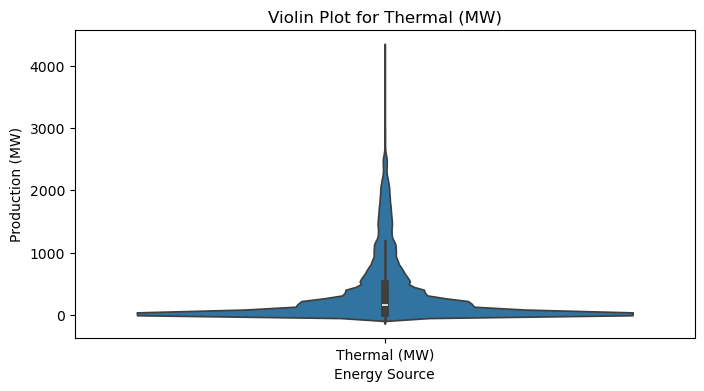

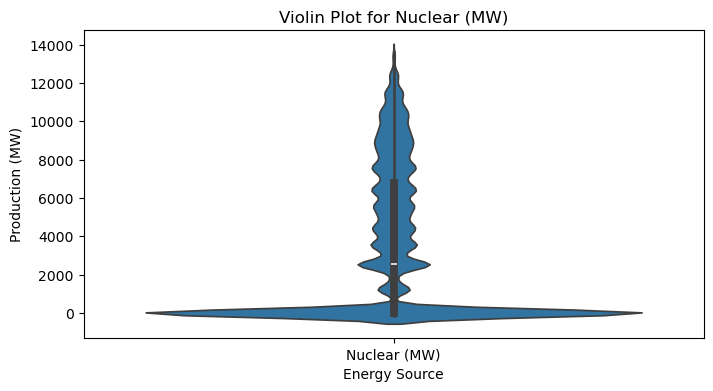

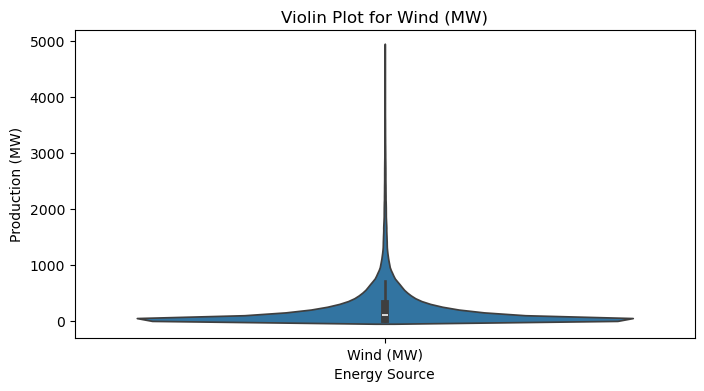

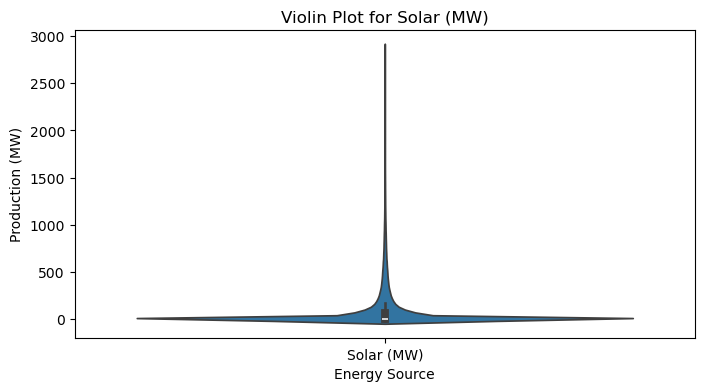

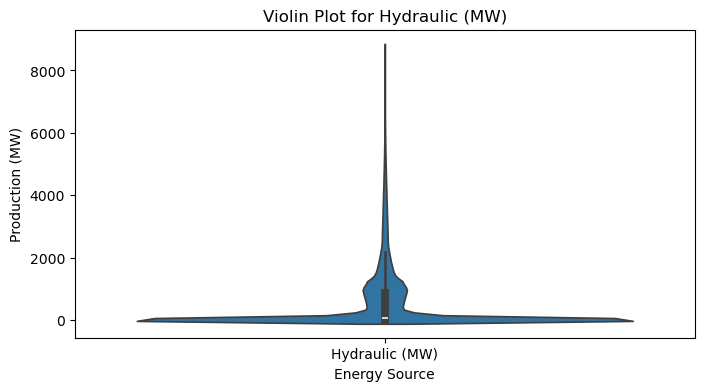

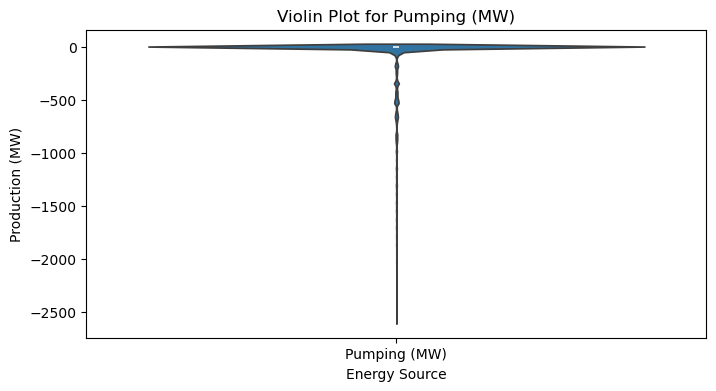

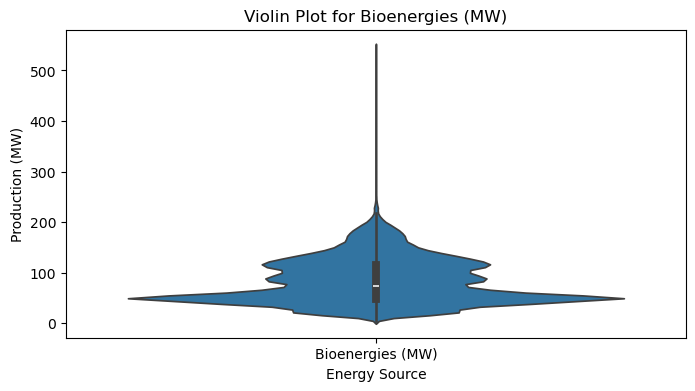

In [19]:
energy_sources = ["Thermal (MW)", "Nuclear (MW)", "Wind (MW)", "Solar (MW)", 
                  "Hydraulic (MW)", "Pumping (MW)", "Bioenergies (MW)"]

melted_df = df.melt(id_vars=["Date - Time", "Region"], 
                    value_vars=energy_sources, 
                    var_name="Energy Source", 
                    value_name="Power (MW)")

for energy in energy_sources:
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=melted_df[melted_df["Energy Source"] == energy],
                   x="Energy Source", 
                   y="Power (MW)")
    plt.title(f"Violin Plot for {energy}")
    plt.xlabel("Energy Source")
    plt.ylabel("Production (MW)")
    plt.show()

Thermal (MW): The distribution indicates that the majority of thermal energy production values are close to zero, with occasional high outliers exceeding 4000 MW.

Nuclear (MW): The nuclear energy production shows a concentrated peak around specific production levels, with a wider range and significantly high outputs, reflecting its role as a primary energy source.

Wind (MW): Wind energy production demonstrates a sharp peak near zero, with fewer occurrences of high production values, suggesting variability and dependence on weather conditions.

Solar (MW): Solar energy production is mostly clustered around very low values, emphasizing its limited use during certain times (e.g., nighttime or cloudy weather).

Hydraulic (MW): Hydraulic energy has a wider range, with production often near lower levels but reaching significant peaks, reflecting its potential variability based on water availability.

Pumping (MW): Pumping data is heavily skewed with values near zero but includes negative outputs, likely indicating its dual nature as a storage and consumption mechanism.

Bioenergies (MW): Bioenergy production is relatively stable, with a moderate range and occasional peaks, indicating steady but limited contributions to the energy mix.